In [100]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statsmodels.api as sm
import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


# Problem: Stayzilla Listing Room Price Prediction

# 1. Visual EDA

In [13]:
# price_data = clean_data
# price_data.to_csv('priceData.csv')
price_data = pd.read_csv("priceData.csv")
price_data = price_data.iloc[:,2:].drop(columns=['property_id'])

In [101]:
price_data

,room_price,image_count,adult_occupancy,child_occupancy,num_amenities,zones,descr_len,deluxe,num_simhotel,wifi,...,acceptance_rate,response_label,Apartment,Homestay,Hotel,House,Lodge,Resort,Spa,Villa
0,3167.0,3.0,3.0,2.0,1.0,2.0,125.0,0.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,815.0,0.0,2.0,2.0,2.0,0.0,103.0,0.0,6.0,0.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1624.0,18.0,2.0,2.0,4.0,3.0,106.0,1.0,14.0,0.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3509.0,9.0,1.0,2.0,7.0,2.0,126.0,0.0,0.0,1.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5802.0,5.0,2.0,2.0,2.0,0.0,126.0,1.0,3.0,0.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,1736.0,5.0,1.0,2.0,4.0,0.0,98.0,0.0,10.0,1.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1135,2595.0,15.0,1.0,2.0,1.0,0.0,147.0,0.0,14.0,1.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1136,2267.0,13.0,1.0,2.0,1.0,0.0,119.0,1.0,12.0,0.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1137,2446.0,16.0,1.0,2.0,1.0,0.0,98.0,0.0,3.0,0.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
from scipy.stats import iqr
1.5*iqr(price_data.room_price) + price_data.room_price.mean(),  price_data.room_price.mean() - 1.5*iqr(price_data.room_price) 

(4532.537313432836, -159.46268656716438)

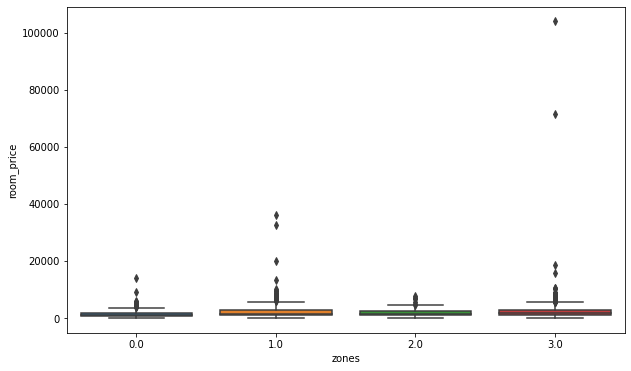

In [102]:
# check the room price outliner 
sns.boxplot(x="zones", y="room_price", data=price_data)

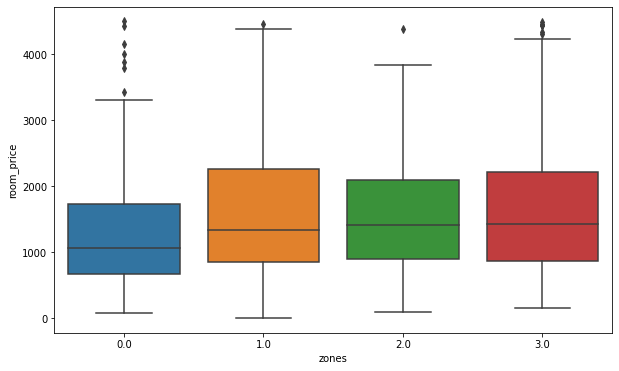

In [103]:
# remove price higher than $20000 or less than $10
# clean_data = clean_data[(clean_data.room_price < 20000) & (clean_data.room_price > 10)]
# further remove outlier: price higher than $4000 or less than $10
# train_data = price_data[(price_data.room_price < 4536) & (price_data.room_price > 0)]
train_data = price_data[(price_data.room_price < 4536) & (price_data.room_price > 0)]

sns.boxplot(x="zones", y="room_price", data=train_data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae01643110>,
      dtype=object)

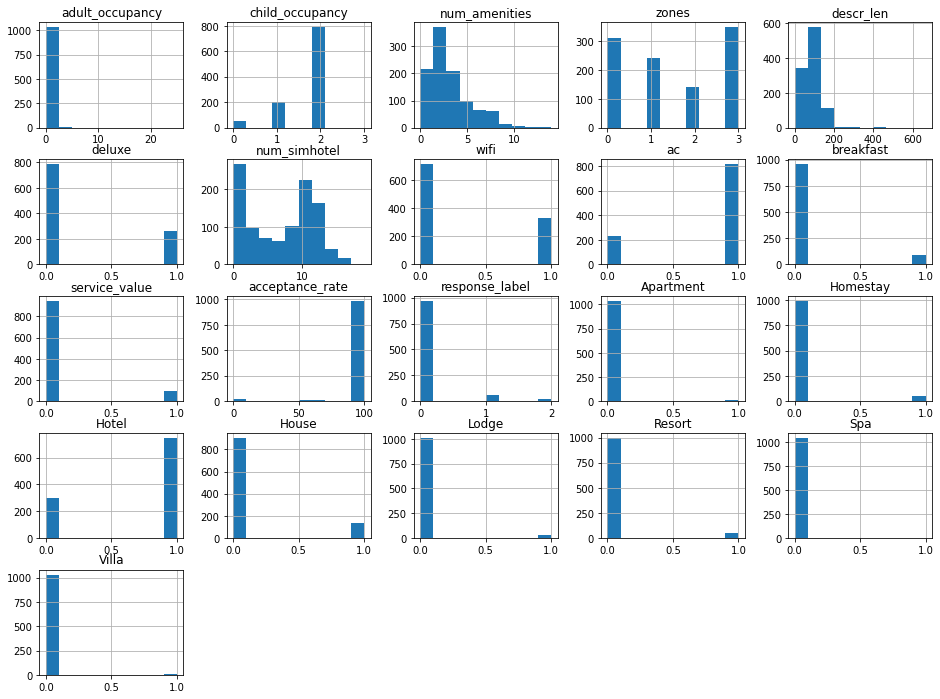

In [104]:
train_data.iloc[:,2:].hist(figsize=(16,12))

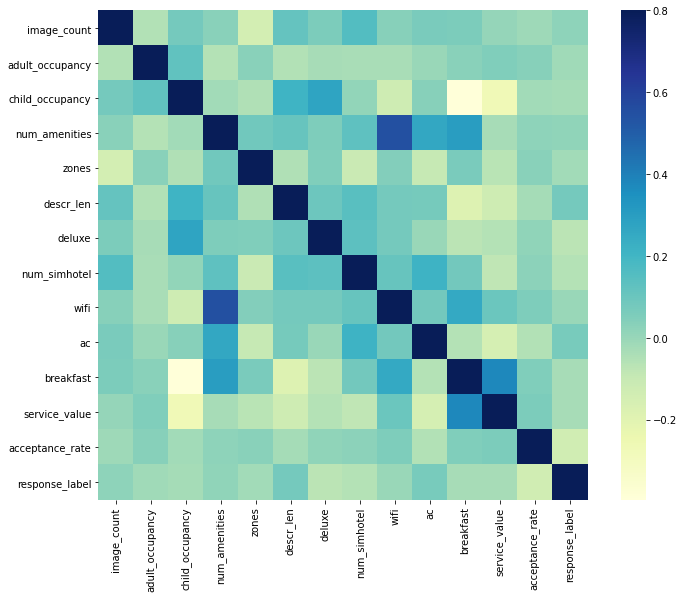

In [18]:
# check the correlation 
corrmat = train_data.iloc[:, 1:-8].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu");

# 2. Prediction

## 2.1 Linear regression using Gradien descent  

In [131]:
# fit all features 
import numpy as np
X = preprocessing.scale(train_data.iloc[:,1:])
X = sm.add_constant(X)
y = train_data.iloc[:,0]
y = y.to_numpy()
y = np.expand_dims(y, axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)


In [132]:
# define a gradient descent function 
def grad_descent(X, y, alpha, epsilon):
    iteration = [0]
    i = 0
    theta = np.ones(shape=(X.shape[1], 1))
    
    # X = X + np.array([1,0])
    
    cost = [np.transpose(X @ theta - y) @ (X @ theta - y)]
    delta = 1
    while (delta>epsilon):
        
        theta = theta - alpha*((np.transpose(X)) @ (X @ theta - y))
        cost_val = (np.transpose(X @ theta - y)) @ (X @ theta - y)
        cost.append(cost_val)
        delta = abs(cost[i+1]-cost[i])
        if ((cost[i+1]-cost[i]) > 0):
            print("The cost is increasing. Try reducing alpha.")
            break
        iteration.append(i)
        i += 1
        
    print("Completed in %d iterations." %(i))
    return theta, cost 


# get the theta

theta1, cost_hist1 = grad_descent(X = X_train, y=y_train, alpha=0.0005, epsilon = 10**-10)
#theta = result[0]
#print(theta)

The cost is increasing. Try reducing alpha.
Completed in 162 iterations.


Text(0.5, 1.0, 'Convergence of gradient descent')

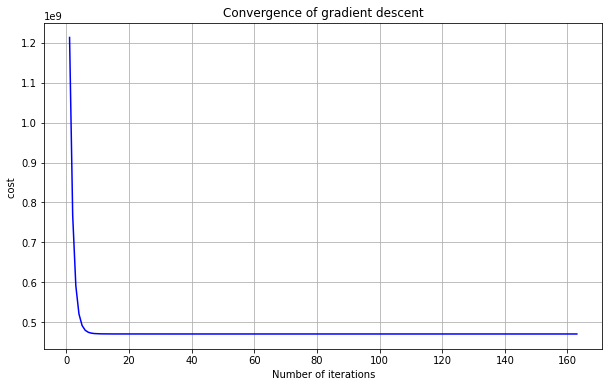

In [133]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(cost_hist1)), [cost_hist1[i][0][0] for i in range(1, len(cost_hist1))], color ='blue')
plt.rcParams["figure.figsize"] = (10,6)
plt.grid()
plt.xlabel("Number of iterations")
plt.ylabel("cost ")
plt.title("Convergence of gradient descent")

In [134]:
# test model 
y_hat = X_test.dot(theta1)

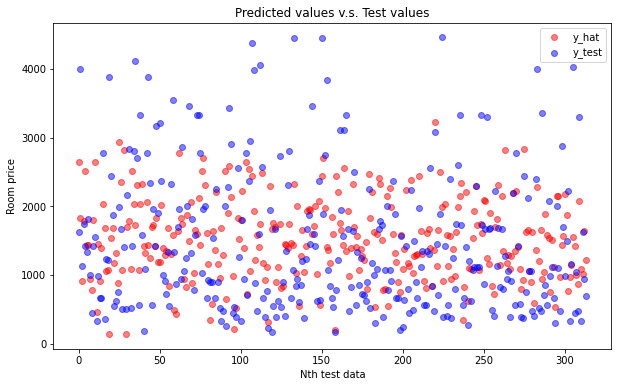

In [135]:
# plot to see the prediction results 
plt.figure()
plt.scatter(x=list(range(0, len(y_hat))),y= y_hat, color='red', alpha=0.5, label='y_hat')         
plt.scatter(x=list(range(0, len(y_test))), y=y_test, color='blue', alpha=0.5, label='y_test')
plt.xlabel("Nth test data")
plt.ylabel('Room price')
plt.title("Predicted values v.s. Test values")
plt.legend()
plt.show()

In [136]:
# evaluate MSE
from sklearn.metrics import mean_squared_error 
y_true_GD = y_test # Y_true = Y (original values) 
y_pred_GD = y_hat # Y_pred = Y' 
# Calculation of Mean Squared Error (MSE) 
GD_testMSE = mean_squared_error(y_true_GD,y_pred_GD) 
print('GD test MSE:', GD_testMSE)

y_true_train_GD = y_train  
y_pred_train_GD = X_train.dot(theta1)  
# Calculation of Mean Squared Error (MSE) 
GD_trainMSE = mean_squared_error(y_true_train_GD,y_pred_train_GD) 
print('GD train MSE:', GD_trainMSE)

GD test MSE: 774490.4931630456
GD train MSE: 643890.5797246874


In [137]:
from sklearn.metrics import r2_score
gd_r2 = r2_score(y_true_GD,y_pred_GD)
gd_r2

0.2284730205918145

## 2.2 Linear regression 

In [138]:
# fit all features 
X = train_data.iloc[:,1:]
X = sm.add_constant(X)
y = train_data.iloc[:,0]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

lr_model = sm.OLS(y_train, X_train).fit()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             room_price   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     15.79
Date:                Tue, 09 Mar 2021   Prob (F-statistic):           3.04e-46
Time:                        17:15:15   Log-Likelihood:                -5905.6
No. Observations:                 730   AIC:                         1.186e+04
Df Residuals:                     708   BIC:                         1.196e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             847.5374    208.491      4.065      0.000     438.203    1256.872
image_count         0.7671      2.060      0.372      0.710      -3.276       4.811
adult_occupancy    16.1402     23.414      0.689      0.491     -29.828      62.109
child_occupancy    59.2868     62.921      0.942      0.346     -64.248     182.821
num_amenities      23.0272     17.551      1.312      0.190     -11.432      57.486
zones              52.8358     25.167      2.099      0.036       3.425     102.246
descr_len           2.5444      0.535      4.760      0.000       1.495       3.594
deluxe            616.9758     74.385      8.294      0.000     470.934     763.017
num_simhotel        8.4364      6.550      1.288      0.198      -4.423      21.296
wifi              332.8403     79.167      4.204      0.000     177.410     488.271
ac               -353.4059     80.830     -4.372      0.000    -512.100    -194.711
breakfast         104.9166    139.632      0.751      0.453    -169.226     379.059
service_value     176.6199    126.664      1.394      0.164     -72.063     425.303
acceptance_rate     1.5877      1.723      0.921      0.357      -1.795       4.971
response_label   -234.3542     84.519     -2.773      0.006    -400.291     -68.417
Apartment        1396.6140    285.305      4.895      0.000     836.469    1956.759
Homestay         -352.7220    156.646     -2.252      0.025    -660.269     -45.175
Hotel              57.2214     96.685      0.592      0.554    -132.603     247.046
House            -472.1653    117.136     -4.031      0.000    -702.140    -242.191
Lodge            -441.4107    183.599     -2.404      0.016    -801.875     -80.947
Resort            726.7577    159.396      4.559      0.000     413.813    1039.703
Spa               -97.6017    511.541     -0.191      0.849   -1101.921     906.718
Villa              30.8440    269.815      0.114      0.909    -498.889     560.577
==============================================================================
Omnibus:                       67.870   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.128
Skew:                           0.786   Prob(JB):                     3.27e-19
Kurtosis:                       3.572   Cond. No.                     9.01e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.6e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Feature: 0, Score: 0.00000
Feature: 1, Score: 2.77512
Feature: 2, Score: 11.70867
Feature: 3, Score: 89.69888
Feature: 4, Score: -5.85537
Feature: 5, Score: 36.75187
Feature: 6, Score: 2.71201
Feature: 7, Score: 562.74291
Feature: 8, Score: 4.56506
Feature: 9, Score: 375.73751
Feature: 10, Score: -280.14921
Feature: 11, Score: 360.12982
Feature: 12, Score: 174.07887
Feature: 13, Score: 2.60212
Feature: 14, Score: -259.82389
Feature: 15, Score: 1280.79550
Feature: 16, Score: -388.90856
Feature: 17, Score: 55.87086
Feature: 18, Score: -480.47559
Feature: 19, Score: -575.11400
Feature: 20, Score: 350.76873
Feature: 21, Score: -155.79826
Feature: 22, Score: -87.13868


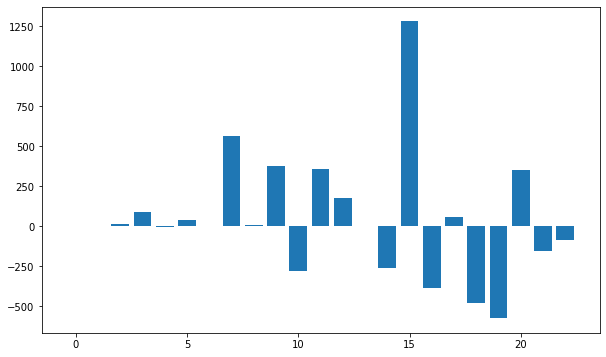

In [114]:
# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
# define dataset
# define the model
model = LinearRegression()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [115]:
# # after checking, remove some non-essential features 
# X = train_data.iloc[:,np.r_[2:16,18:20]]
# X = sm.add_constant(X)
# y = train_data.iloc[:,1]
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

# lr_model = sm.OLS(y_train, X_train).fit()
# lr_model.summary()


* We first fit all relevant features to the linear regression model using statsmodel. The adjusted R2 only achieves 0.272. We then removed some non-essential features (eg. 'Spa', 'Villa', very few rows have 1 values), the R2 does not increase (0.218). 
* We then perform a Stepwise selection in R and it returns a model with 13 features, but the adjusted R2 is only 0.1746, less than models with more features. 
* For linear regression model, we will stick with all features.

In [139]:
# compute test MSE 
y_true_lr = y_test # Y_true = Y (original values) 
y_pred_lr = lr_model.predict(X_test) # Y_pred = Y' 
lr_testMSE = mean_squared_error(y_true_lr,y_pred_lr) 

# training mse
y_true_train_lr = y_train  
y_pred_train_lr = lr_model.predict(X_train) 
lr_trainMSE = mean_squared_error(y_true_train_lr,y_pred_train_lr) 
print(lr_testMSE, lr_trainMSE)

# r2
lr_r2 = r2_score(y_true_lr, y_pred_lr)
lr_r2


796295.0129231175 622661.496609513


0.1941859575771584

* ### Additional try#1: predict in per zone

In [184]:
zone0 = train_data[train_data.zones==0].drop(columns='zones')
zone1 = train_data[train_data.zones==1].drop(columns='zones')
zone2 = train_data[train_data.zones==2].drop(columns='zones')
zone3 = train_data[train_data.zones==3].drop(columns='zones')

In [187]:
# X = zone3.iloc[:,2:]
# X = sm.add_constant(X)
# y = zone3.iloc[:,1]
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

# lr_model = sm.OLS(y_train, X_train).fit()
# lr_model.summary()

/Users/yajiezhu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             room_price   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     7.053
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           1.86e-14
Time:                        12:58:01   Log-Likelihood:                -1864.6
No. Observations:                 234   AIC:                             3769.
Df Residuals:                     214   BIC:                             3838.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             940.6670    403.693      2.330      0.021     144.943    1736.391
image_count         3.6919      3.939      0.937      0.350      -4.072      11.455
adult_occupancy   -56.0928     78.646     -0.713      0.476    -211.113      98.927
child_occupancy    -1.3125     95.173     -0.014      0.989    -188.909     186.284
num_amenities      20.3071     26.571      0.764      0.446     -32.067      72.681
descr_len           0.4495      0.978      0.459      0.646      -1.479       2.378
deluxe            510.3983    119.998      4.253      0.000     273.869     746.928
num_simhotel       29.4450     10.638      2.768      0.006       8.477      50.413
wifi              524.8552    124.966      4.200      0.000     278.532     771.178
ac               -334.2704    121.654     -2.748      0.007    -574.065     -94.476
breakfast          60.3859    224.546      0.269      0.788    -382.220     502.992
service_value     343.6611    228.919      1.501      0.135    -107.565     794.887
acceptance_rate     0.3902      3.952      0.099      0.921      -7.400       8.180
response_label   -482.8702    224.971     -2.146      0.033    -926.314     -39.427
Apartment        1090.4852    291.373      3.743      0.000     516.157    1664.814
Homestay         -409.9101    332.634     -1.232      0.219   -1065.569     245.748
Hotel             211.8204    148.366      1.428      0.155     -80.626     504.267
House             -65.5355    184.871     -0.354      0.723    -429.937     298.865
Lodge            -485.2499    386.194     -1.256      0.210   -1246.481     275.981
Resort            702.0840    306.774      2.289      0.023      97.398    1306.770
Spa                      0          0        nan        nan           0           0
Villa            -103.0270    500.691     -0.206      0.837   -1089.944     883.890
==============================================================================
Omnibus:                       11.194   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.787
Skew:                           0.549   Prob(JB):                      0.00276
Kurtosis:                       3.041   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

* The prediction results per zone do not significantly. This indicates that the low performance for linear regression prediction may be because the lack of substantial features related to room price such as the room area, and the decoration of rooms. 

## 2.3 Random Forest Regression

In [140]:
from sklearn.ensemble import RandomForestRegressor
X = preprocessing.scale(train_data.iloc[:,1:])
y = train_data.iloc[:,0]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

rr = RandomForestRegressor(n_estimators = 1000)
rr.fit(X_train, y_train.values.ravel())

RandomForestRegressor(n_estimators=1000)

In [141]:
y_true_train_rr = y_train  
y_pred_train_rr = rr.predict(X_train) 
rr_trainMSE = mean_squared_error(y_true_train_rr,y_pred_train_rr) 

y_true_rr = y_test # Y_true = Y (original values) 
y_pred_rr = predictions = rr.predict(X_test) # Y_pred = Y' 
rr_testMSE = mean_squared_error(y_true_rr,y_pred_rr) 
rr_trainMSE, rr_testMSE

(87812.80993750671, 764643.0317591359)

In [142]:
# calculate r2
from sklearn.metrics import r2_score
rr_r2 = r2_score(y_true_rr, y_pred_rr)
rr_r2

0.23025769367994742

## 2.4 Neural Network

In [143]:
# define x, y
X = train_data.iloc[:,1:].values
y = train_data.iloc[:,0].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

In [144]:
# define NN model
nn = Sequential()
nn.add(Dense(21, activation='relu'))
nn.add(Dense(500,activation='relu'))
# nn.add(Dense(2, activation='relu')) # hidden layer 6 
nn.add(Dense(1, activation='linear'))
nn.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])
nn.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
27/27 [==============================] - 0s 7ms/step - loss: 3444262.1161 - mse: 3444262.1161 - mae: 1567.4749 - val_loss: 3021961.5000 - val_mse: 3021961.5000 - val_mae: 1462.1315
Epoch 2/10
27/27 [==============================] - 0s 10ms/step - loss: 3263880.2321 - mse: 3263880.2321 - mae: 1521.9460 - val_loss: 2984469.7500 - val_mse: 2984469.7500 - val_mae: 1449.3738
Epoch 3/10
27/27 [==============================] - 0s 3ms/step - loss: 3074682.6161 - mse: 3074682.6161 - mae: 1486.1563 - val_loss: 2900053.7500 - val_mse: 2900053.7500 - val_mae: 1420.9293
Epoch 4/10
27/27 [==============================] - 0s 3ms/step - loss: 3231369.7857 - mse: 3231369.7857 - mae: 1498.7968 - val_loss: 2741462.2500 - val_mse: 2741462.2500 - val_mae: 1367.2582
Epoch 5/10
27/27 [==============================] - 0s 3ms/step - loss: 2810582.9732 - mse: 2810582.9732 - mae: 1394.5622 - val_loss: 2490066.2500 - val_mse: 2490066.2500 - val_mae: 1280.2321
Epoch 6/10
27/27 [=====================

In [145]:
y_true_train = y_train  
y_pred_train = nn.predict(X_train) 
nn_trainMSE = mean_squared_error(y_true_train,y_pred_train) 

y_true_nn = y_test # Y_true = Y (original values) 
y_pred_nn = predictions = rr.predict(X_test) # Y_pred = Y' 
nn_testMSE = mean_squared_error(y_true_nn,y_pred_nn) 
nn_trainMSE, nn_testMSE

(826295.1426503576, 315551.7799861846)

In [146]:
nn_r2 = r2_score(y_true_nn, y_pred_nn)
nn_r2

0.6430226578800646

* Using neural network still does not yield good results. 
* We may conclude that the features in the dataset do not affect price very much. 

# 3. Wrap-up

In [149]:
# store all model metrics 
result = {'gradienr_descent': [GD_trainMSE, GD_testMSE, gd_r2], 
         'linear_regression': [lr_trainMSE, lr_testMSE, lr_r2], 
         'random_forest':[rr_trainMSE, rr_testMSE, rr_r2], 
         'neural_network': [nn_trainMSE, nn_testMSE, nn_r2]}
df = pd.DataFrame.from_dict(result,orient='index', columns=['training_MSE', 'test_MSE', 'test_R2'])

Text(0.5, 1.0, 'MSE - Four Models')

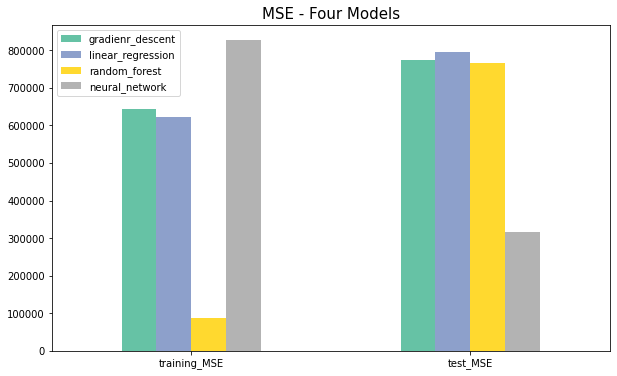

In [210]:
df2 = df.transpose()
df2.iloc[:2,:].plot(kind='bar',colormap='Set2', rot=0)
plt.title('MSE - Four Models', fontsize=15)

Text(0.5, 1.0, 'R square - Four Models')

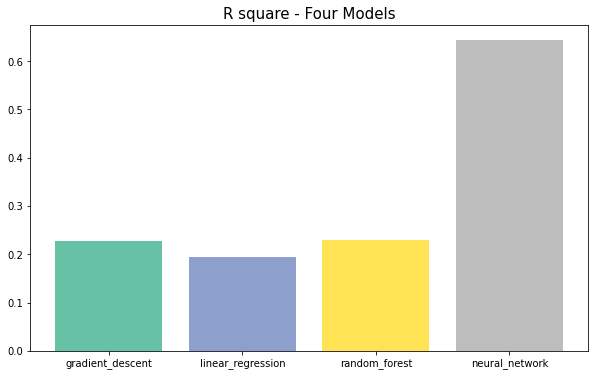

In [212]:
plt.bar(x=['gradient_descent', 'linear_regression','random_forest', 'neural_network'], 
            height=df2.iloc[2,:],color=['#66c2a5', '#8da0cb', '#ffe355', '#bdbdbd'])
plt.title('R square - Four Models',fontsize=15)

# 4. Alternative: try Predict price range

* I grouped the price into 6 buckets and to see if turning it into a classification problem would yield better result or not. 

/Users/yajiezhu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


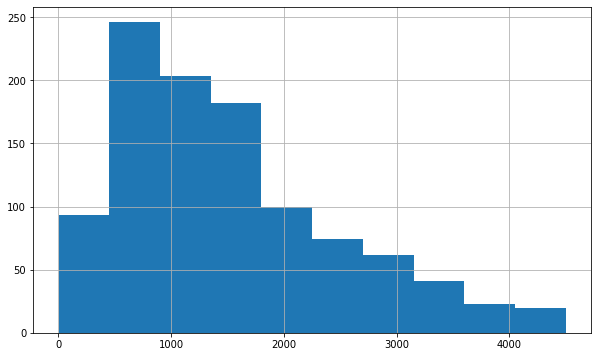

In [213]:
# divide price into groups
train_data.room_price.hist(bins=10)
# split the price into 6 groups
train_data['price_group'] = train_data.room_price.apply(lambda x: 1 if x<=500 else(2 if x <=1000 else(3 if x<=1500 else(4 if x<=2000 
                                                                                                                        else(5 if x<=2500 
                                                                                                                             else 6)))))
                                                                                                    

## 4. 1 Random forest classifier 

In [67]:
from sklearn.ensemble import RandomForestClassifier

X = train_data.iloc[:,1:-1].values
y = train_data.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

rfc = RandomForestClassifier(n_estimators=100) # too many will waste computation power
clf = rfc.fit(X_train, y_train.values.ravel()) # ravel will give the right format for random forest

predictions = rfc.predict(X_test)

In [68]:
print(accuracy_score(y_test, predictions))

0.4258373205741627


## 4.2 Neural Network classifier

In [89]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoder = OneHotEncoder()
group = encoder.fit_transform(train_data[['price_group']])
ydf = pd.DataFrame(group.toarray(), columns=encoder.categories_)

train_data_encoded = pd.concat([train_data.iloc[:,1:-1], ydf], axis=1)

In [91]:
train_data_encoded.iloc[:,0:-6]

,image_count,adult_occupancy,child_occupancy,num_amenities,zones,descr_len,deluxe,num_simhotel,wifi,ac,...,service_value,acceptance_rate,response_label,Apartment,Homestay,Hotel,House,Lodge,Resort,Spa
0,3.0,3.0,2.0,1.0,2.0,125.0,0.0,0.0,0.0,0.0,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,2.0,2.0,2.0,0.0,103.0,0.0,6.0,0.0,1.0,...,0.0,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,18.0,2.0,2.0,4.0,3.0,106.0,1.0,14.0,0.0,1.0,...,0.0,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,9.0,1.0,2.0,7.0,2.0,126.0,0.0,0.0,1.0,1.0,...,0.0,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,5.0,1.0,2.0,4.0,0.0,98.0,0.0,10.0,1.0,1.0,...,0.0,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1135,15.0,1.0,2.0,1.0,0.0,147.0,0.0,14.0,1.0,0.0,...,0.0,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1136,13.0,1.0,2.0,1.0,0.0,119.0,1.0,12.0,0.0,0.0,...,0.0,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1137,16.0,1.0,2.0,1.0,0.0,98.0,0.0,3.0,0.0,0.0,...,0.0,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [99]:
# neural network 

# define x, y
X = train_data_encoded.iloc[:,0:-6].values
y = train_data_encoded.iloc[:,-6:].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

# define NN baseline  model
nn = Sequential()
nn.add(Dense(21, activation='relu'))
nn.add(Dense(8,activation='relu'))
nn.add(Dense(6, activation='softmax'))
nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.1808 - val_loss: nan - val_accuracy: 0.1982
Epoch 2/20
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.1914 - val_loss: nan - val_accuracy: 0.1982
Epoch 3/20
29/29 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.1678 - val_loss: nan - val_accuracy: 0.1982
Epoch 4/20
29/29 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.1850 - val_loss: nan - val_accuracy: 0.1982
Epoch 5/20
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.1911 - val_loss: nan - val_accuracy: 0.1982
Epoch 6/20
29/29 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.1873 - val_loss: nan - val_accuracy: 0.1982
Epoch 7/20
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.1640 - val_loss: nan - val_accuracy: 0.1982
Epoch 8/20
29/29 [==============================] - 0s 3ms/ste

* Accuracy using NN is around 20%, much lowerer than random forest. 